<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Spacegroup_specific_endeavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

ModuleNotFoundError: No module named 'mp_api'

In [ ]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

In [ ]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5)


In [5]:
material_positions_frac = []
material_positions = []
bandgaps = []
for m in example_docs:
  single_material_positions = []
  single_material_frac_positions = []
  for site in m.structure.sites:
    frac_coords = site.frac_coords
    single_material_frac_positions.append(site.frac_coords)
    single_material_positions.append(site.coords)

  material_positions_frac.append(single_material_frac_positions)
  material_positions.append(single_material_positions)
  bandgaps.append(m.band_gap)

In [6]:
all_material = []

for group in material_positions_frac:
  unique_positions = []
  for coord in group:
      # Round to 4 decimal places to eliminate noise
      rounded = tuple(np.round(coord % 1, 4))  # mod 1 ensures coords are in [0, 1)
      unique_positions.append(rounded)
  all_material.append(unique_positions.copy())

In [7]:
df = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps)),
               columns =['all_material', 'material_positions', 'bandgaps'])

In [8]:
df

,all_material,material_positions,bandgaps
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031
3,"[[0.0, 0.0, 0.0], [0.499998, 0.499998, 0.49999...","[[0.0, 0.0, 0.0], [1.9566577983375, 1.95665779...",0.0000
4,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888
...,...,...,...
1453,"[[0.0, 0.0, 0.0], [-0.0, 0.5, 0.5], [0.5, -0.0...","[[0.0, 0.0, 0.0], [0.0, 2.03775825, 2.03775825...",0.0000
1454,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.8317364999999994, 1.83173...",0.0000
1455,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9295495, 1.9295495, 1.929...",0.0000
1456,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, ...","[[2.106323, 2.106323, 2.106323], [0.0, 0.0, 0....",0.0000


In [9]:
import numpy as np

def find_wyckoff_1b_3c_indices(coords):
    # Normalize and round for matching
    rounded_coords = [tuple(np.round(np.array(c) % 1, 6)) for c in coords]

    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c_list = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    # Find index of 1b
    try:
        i1b = rounded_coords.index(wyckoff_1b)
    except ValueError:
        i1b = None

    # Find index of any 3c
    i3c = None
    for w3c in wyckoff_3c_list:
        if w3c in rounded_coords:
            i3c = rounded_coords.index(w3c)
            break

    both_found = i1b is not None and i3c is not None

    return i1b, i3c, both_found

In [10]:
distances = []
band_gaps = []
for data in df.values:
  pos1b, pos3c, both = find_wyckoff_1b_3c_indices(data[0])
  if both:
    distance = np.linalg.norm(data[1][pos1b] - data[1][pos3c])
    distances.append(distance)
    band_gaps.append(data[2])


In [11]:
df = pd.DataFrame(list(zip(distances, band_gaps)),
               columns =['distances', 'bandgaps'])

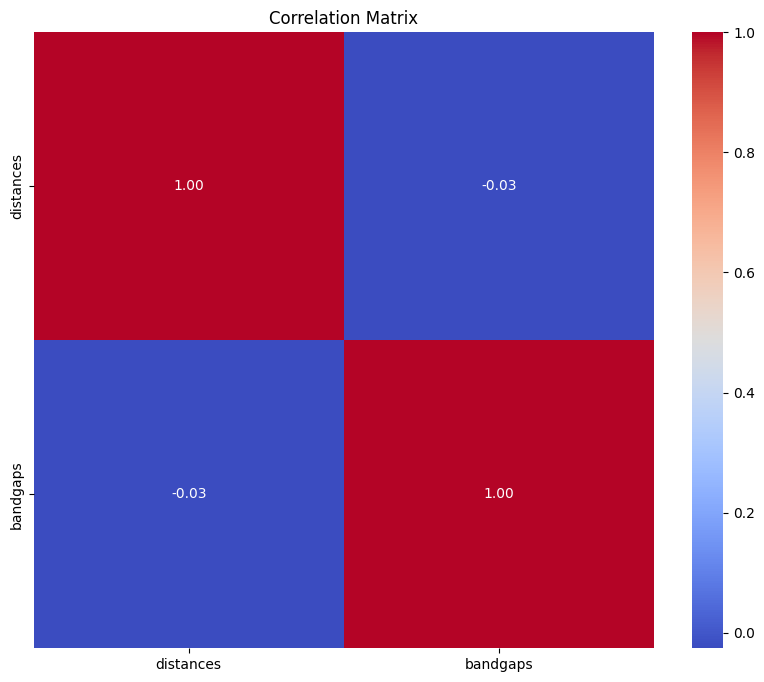

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

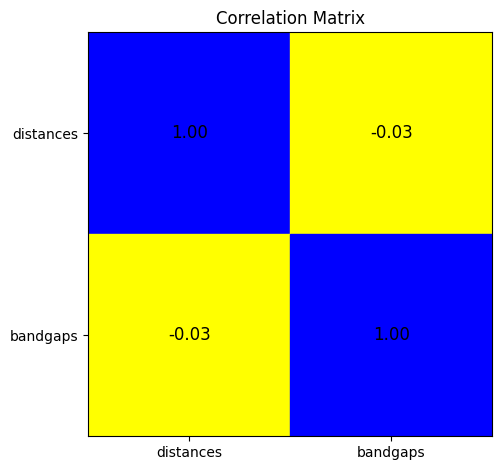

In [13]:
# Compute correlation matrix
corr = df.corr()

# Extract values and labels
values = corr.values
labels = corr.columns.tolist()

# Create custom color matrix
colors = np.array([
    ['blue' if i == j else 'yellow' for j in range(2)]
    for i in range(2)
])

# Plot
fig, ax = plt.subplots()

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i][j]))
        ax.text(j + 0.5, i + 0.5, f"{values[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=12)

# Axis formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

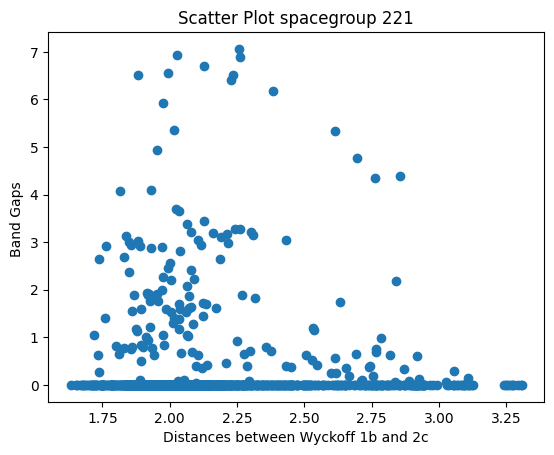

In [18]:
plt.scatter(distances, band_gaps)
plt.xlabel("Distances between Wyckoff 1b and 2c")
plt.ylabel("Band Gaps ")
plt.title("Scatter Plot spacegroup 221")
plt.show()


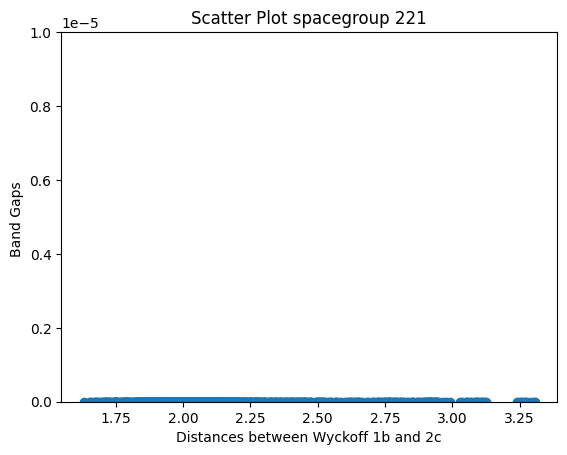

In [24]:
plt.scatter(distances, band_gaps)
plt.xlabel("Distances between Wyckoff 1b and 2c")
plt.ylabel("Band Gaps ")
plt.ylim(0 , .00001)
plt.title("Scatter Plot spacegroup 221")
plt.show()


In [ ]:
check if all have 3 atoms in 3c
electrons probably not

check if all have 3 atoms in 3c
electrons probably not useful

radius

contributing electrons
p for X
and p and s for B